# Setup

In [68]:
DATA_VERSION = "2025-07-14"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
DOCUMENT_EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)
CONSULTATION_EMBEDDINGS_FILE_NAME = (
    f"consultation-attributes-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)


LANGUAGES = {
    "de",
    # "fr",
    # "it",
}
TOPIC_LABEL_SOURCES = {
    # "openparldata",
    # "organisation_rule",
    "manual",
}

# FROM_YEAR = 2010
FROM_YEAR = 2000

MIN_CONSULTATIONS_IN_CLASS = 40
IGNORE_TOPICS = {
    # "administration",
    # "communications",
}

DOC_TYPES = {
    "DRAFT",
    # None,  # Many openparldata documents don't have a known type
    # "VARIOUS_TEXT",
    # "LETTER",
    # "RECIPIENT_LIST",  # proven to not be useful
    # "REPORT",
    # "FINAL_REPORT",
    # "OPINION",
    # "SYNOPTIC_TABLE",  # possibly not useful?
    # "SURVEY",
    # "RESPONSE_FORM",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 271

In [69]:
%load_ext autoreload
%autoreload 2

import pathlib
import sys
from typing import Any

import dotenv
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import demokratis_ml.models.consultation_topics.preprocessing
from research.consultation_topics import data_transformations
from research.lib import data_access, plotting, stratified_group_split, utils

In [71]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_document_topic_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("document_embeddings_file", DOCUMENT_EMBEDDINGS_FILE_NAME)
mlflow.log_param("consultation_embeddings_file", CONSULTATION_EMBEDDINGS_FILE_NAME)
mlflow.log_param("topic_label_sources", sorted(TOPIC_LABEL_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("min_consultations_in_class", MIN_CONSULTATIONS_IN_CLASS)
mlflow.log_param("ignore_topics", sorted(IGNORE_TOPICS))
mlflow.log_param("doc_types", sorted(map(str, DOC_TYPES)))
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = flawless-cod-402


''

In [72]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/07/15 10:01:58 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [75]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)
DOCUMENT_EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DOCUMENT_EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(DOCUMENT_EMBEDDINGS_DATA_FILE)
CONSULTATION_EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / CONSULTATION_EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(CONSULTATION_EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-07-14.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-07-14.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-attributes-embeddings-beginnings-openai-text-embedding-3-large-2025-07-14.parquet already exists locally.


In [76]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_languages=LANGUAGES,
    only_doc_types=DOC_TYPES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_docs = df_docs[df_docs["consultation_topics_label_source"].isin(TOPIC_LABEL_SOURCES)]
df_docs

,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_uuid,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wffQLMxGCHhjJ6PKmR,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
21,1CAJoURregQSBjKq3Pp2mL,a49pncfq,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,"[communications, it, security]","[{'created_at': 2025-01-27 11:30:14, 'name': '...",...,Bundesamt für Kommunikation,ch,1CM3wg6vz2uQ3oZqEQcf7s,fedlex,manual,fedlex,[Signature] \n[QR Code] \n \n1 \nVerordnung \n...,2024/2/22/1CM3wg6vjrx6u67JD8PayD.pdf,application/pdf,8fb68017e53055498c277ed8afe60d56ee2935aa
42,1CAJoUSHBj4qdYJPe3PFcd,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgUgRrjEFontegfgyd,fedlex,manual,fedlex,2021-… \n \nVerordnung \n \n \n \nVernehmlass...,2024/3/43/1CM3wgUcDxsq2yKqdZsaGe.pdf,application/pdf,98a60f2d0b0b0ce18b5ce82a1e9df248c3629bb9
51,1CAJoUSHBj4qdYJPedbRja,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgwv3CkfxghjShq2NP,fedlex,manual,fedlex,1 \nRaumplanungsverordnung \n \nVernehmlassung...,2024/3/52/1CM3wgwuYYGtzYePP6ETCu.pdf,application/pdf,0ec7371d74bfec45d6b022706fe669bee7005ded
54,1CAJoUSHBj4qdYJPepDs22,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgyzoKLLbozGmFEg75,fedlex,manual,fedlex,2021-… \n \nVerordnung \n \n \n \nVernehmlass...,2024/3/55/1CM3wgyzJL2fSpmyQyW3Uj.pdf,application/pdf,fc01f855d3a18f17ee7b3b9add690ded4d9d2764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53959,1CQXzKRuXrxxk6ymwxFVdW,end6g7hp,2025-06-25,2025-10-15,Änderung des Wasserrechtsgesetzes (Umsetzung M...,Gegenstand der vorliegenden Vernehmlassungsvor...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/end6g7hp,"[energy, environment]","[{'created_at': 2025-05-07 14:07:37, 'name': '...",...,Bundesamt für Energie,ch,1CQdqZXWjjq9rvKbTVwpfU,fedlex,manual,fedlex,«$$e-seal»\n«$$QrCode»\n2024-...\n«%ASFF_YYYY_...,2025/5113/55961/1CQdqZXWVqhRV7H1wXgf1V.pdf,application/pdf,0df91a8ba027b8a2a481771fd88328e066dcf57a
53974,1CQXzKTmtroZUKrXVYMHQq,jh9ctnan,2025-06-25,2025-10-16,Verordnungspaket Umwelt Frühling 2026,"Anpassu

In [77]:
df_document_embeddings = pd.read_parquet(DOCUMENT_EMBEDDINGS_DATA_FILE)
df_document_embeddings

,embedding
document_uuid,
1CAJoURQMxKeqCdQ4jLniS,"[0.01030252780765295, -0.014312159270048141, -..."
1CAJoURQMxKeqCdQ4vhCQx,"[0.011395552195608616, 0.0014780974015593529, ..."
1CAJoURQMxKeqCdQ564eYH,"[-0.005767590366303921, 0.002646328415721655, ..."
1CAJoURQbi5gxw7Wp5N5rT,"[0.019797369837760925, -0.00907826703041792, -..."
1CAJoURQbi5gxw7WpL8ns1,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
1CQq2cR8RAR9368nVmJotB,"[0.006463687866926193, 0.0037266802974045277, ..."
1CQq2cR8RAR9368nVrayp9,"[0.013085871003568172, -0.010078459046781063, ..."
1CQzVcZwRMubJVL3zmzPPX,"[0.011624314822256565, -0.030158638954162598, ..."


In [78]:
df_consultation_embeddings = pd.read_parquet(CONSULTATION_EMBEDDINGS_DATA_FILE)
df_consultation_embeddings

,,,text,embedding
consultation_identifier,attribute_language,attribute_name,,
222gq6cs,de,consultation_title,Gesetz über die Ausbildungsbeiträge (Stipendie...,"[-0.006880167871713638, 0.02503645420074463, -..."
2259wqvq,de,consultation_title,Revision der Asylverordnung 2 über Finanzierun...,"[0.019555626437067986, 0.038168445229530334, -..."
22acxr55,de,consultation_title,Evaluation Kindes- und Erwachsenenschutzrecht ...,"[-0.024509185925126076, 0.01123279333114624, -..."
22fcru5x,de,consultation_title,Revision der Verordnung 2 zum Arbeitsgesetz (A...,"[0.01675618812441826, 0.023464420810341835, -0..."
22mkgk7j,de,consultation_title,Änderung der Verordnung über die CO2-Abgabe (C...,"[-0.0014414963079616427, -0.00654450012370944,..."
...,...,...,...,...
zzy2ettp,de,organisation_name,Regierungsrat des Kantons Aargau,"[0.029343530535697937, -0.008861028589308262, ..."
a9j4assx,de,consultation_description,Primär soll die landwirtschaftliche Beratung a...,"[0.014760013669729233, 0.00452077342197299, -0..."
qju8bcrr,de,consultation_description,Die Spitalplanung ist regelmässig zu überprüfe...,"[-0.023545196279883385, 0.030222192406654358, ..."


## Create the input dataframe

In [79]:
df_input, topic_columns = demokratis_ml.models.consultation_topics.preprocessing.create_input_dataframe(
    df_docs, df_document_embeddings, df_consultation_embeddings
)
df_input

INFO document_types.preprocessing: Dropping 5 documents (0.3%) with empty texts
INFO document_types.preprocessing: 0 rows were lost due to missing embeddings. Remaining rows: 1610. 1 columns were added.


,consultation_identifier,document_uuid,document_type,document_language,consultation_topics_label_source,embedding,consultation_topics,topic_administration,topic_agriculture,topic_communications,...,topic_media,topic_migration,topic_political_system,topic_public_finance,topic_science,topic_security,topic_social,topic_spatial_planning,topic_sports,topic_transportation
0,7bt3hz2w,1CAJoURQMxKeqCdQ4jLniS,DRAFT,de,manual,"[0.01030252780765295, -0.014312159270048141, -...","[administration, finance, security]",1,0,0,...,0,0,0,0,0,1,0,0,0,0
21,a49pncfq,1CAJoURregQSBjKq3Pp2mL,DRAFT,de,manual,"[-0.0008664852357469499, -0.016210367903113365...","[communications, it, security]",0,0,1,...,0,0,0,0,0,1,0,0,0,0
42,tcspwfam,1CAJoUSHBj4qdYJPe3PFcd,DRAFT,de,manual,"[-0.017760267481207848, 0.00550598930567503, -...","[energy, spatial_planning]",0,0,0,...,0,0,0,0,0,0,0,1,0,0
51,tcspwfam,1CAJoUSHBj4qdYJPedbRja,DRAFT,de,manual,"[-0.005109107121825218, -0.038267649710178375,...","[energy, spatial_planning]",0,0,0,...,0,0,0,0,0,0,0,1,0,0
54,tcspwfam,1CAJoUSHBj4qdYJPepDs22,DRAFT,de,manual,"[-0.025177666917443275, 0.02579987235367298, -...","[energy, spatial_planning]",0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11304,zygt9epc,,organisation_name,de,manual,"[0.0273574311286211, 0.01971733197569847, -0.0...","[energy, health, security]",0,0,0,...,0,0,0,0,0,1,0,0,0,0
11306,zyuux9us,,organisation_name,de,manual,"[0.024208655580878258, -0.0021529097575694323,...","[agriculture, environment, social]",0,1,0,...,0,0,0,0,0,0,1,0,0,0
11308,zzby35xf,,organisation_name,de,manual,"[0.010723001323640347, 0.028152385726571083, -...","[insurance, sports, transportation]",0,0,0,...,0,0,0,0,0,0,0,0,1,1
11312,zzvn2q9r,,organisation_name,de,manual,"[-0.007053430657833815, 0.042377009987831116, ...","[economics, foreign_policy, public_finance]",0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [80]:
df_input["document_type"].value_counts(dropna=False)

document_type
DRAFT                       1610
consultation_title          1049
consultation_description    1049
organisation_name           1049
Name: count, dtype: int64

## Drop underrepresented topics

In [81]:
df_input, topic_columns = demokratis_ml.models.consultation_topics.preprocessing.drop_underrepresented_topics(
    df_input,
    topic_columns,
    MIN_CONSULTATIONS_IN_CLASS,
    always_drop_topics=IGNORE_TOPICS,
)

Dropping these underrepresented classes:
 topic_culture             38
topic_media               11
topic_political_system    37
topic_sports              28
dtype: int64
Dropping these documents without any label: 9


In [82]:
print("Original number of documents:", df_docs.shape[0])
print("Original number of consultations:", df_docs["consultation_identifier"].nunique())
print("\ndf_input size (documents):", df_input.shape[0])
print("df_input size (consultations):", df_input["consultation_identifier"].nunique())

Original number of documents: 1615
Original number of consultations: 1051

df_input size (documents): 4748
df_input size (consultations): 1047


## Split

In [83]:
splitter = stratified_group_split.MultilabelStratifiedGroupShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(
    splitter.split(df_input, df_input[topic_columns], groups=df_input["consultation_identifier"])
)

In [84]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

assert not set(df_input_train["consultation_identifier"]) & set(
    df_input_test["consultation_identifier"]
), "No leakage between train and test sets"

mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (4270, 29)
Test: (478, 29)


# Data exploration

In [85]:
df_input_train.groupby("consultation_identifier").agg({"consultation_topics": "first"}).explode(
    "consultation_topics"
).value_counts()

consultation_topics
economics              221
public_finance         205
security               180
health                 155
administration         149
foreign_policy         130
it                     124
social                 110
environment            108
finance                103
transportation          95
insurance               94
energy                  88
agriculture             86
migration               79
education               71
law                     71
spatial_planning        67
housing                 52
communications          49
defense                 40
science                 40
political_system        34
culture                 31
sports                  20
media                    8
Name: count, dtype: int64

In [86]:
# df_input_train.groupby("consultation_identifier").agg(
#     {"consultation_topics": "first", "consultation_topics_label_source": "first"}
# ).explode("consultation_topics").groupby("consultation_topics")["consultation_topics_label_source"].value_counts()
df_input_train.groupby("consultation_identifier").agg({"consultation_topics_label_source": "first"})[
    "consultation_topics_label_source"
].value_counts()

consultation_topics_label_source
manual               940
openparldata           0
organisation_rule      0
Name: count, dtype: int64

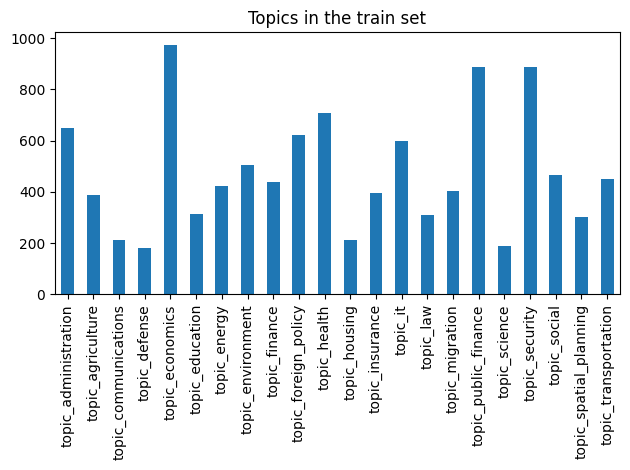

In [87]:
plotting.plot_and_log(
    df_input_train[topic_columns].sum().plot.bar,
    "figures/topics-counts-train.png",
    title="Topics in the train set",
)

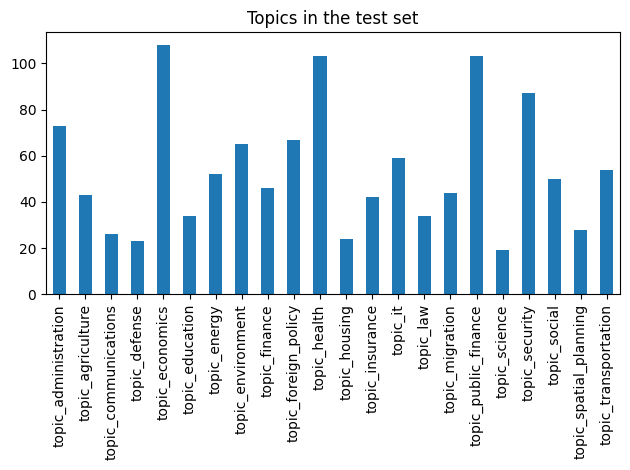

In [88]:
plotting.plot_and_log(
    df_input_test[topic_columns].sum().plot.bar,
    "figures/topics-counts-test.png",
    title="Topics in the test set",
)

# Classification

In [89]:
def create_matrices(df: pd.DataFrame) -> tuple[np.ndarray, pd.DataFrame]:
    x = np.vstack(df["embedding"])
    y = df[topic_columns]
    return x, y


def create_classifier(random_state: int) -> Pipeline:
    return make_pipeline(
        StandardScaler(),
        PCA(n_components=400, random_state=random_state),
        MultiOutputClassifier(
            LogisticRegression(max_iter=1000),
            # RandomForestClassifier(random_state=random_state)
        ),
    )


X_train, y_train = create_matrices(df_input_train)
X_test, y_test = create_matrices(df_input_test)

groups_train = df_input_train["consultation_identifier"]
groups_test = df_input_test["consultation_identifier"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (4270, 3072) (4270, 22)
Test (478, 3072) (478, 22)


## CV

In [90]:
classifier_cv = create_classifier(RANDOM_STATE)
classifier_cv

,steps,"[('standardscaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,400
,copy,True
,whiten,False
,svd_solver,'auto'


In [91]:
cv = stratified_group_split.MultilabelStratifiedGroupKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    """If PCA is used in the pipeline, include its explained variance in scores."""
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


args = {
    "estimator": classifier_cv,
    "X": X_train,
    "y": y_train,
    "groups": groups_train,
    "cv": cv,
    "verbose": 2,
    "n_jobs": -1,
}

print("cross_validate...")
cv_scores_docs = sklearn.model_selection.cross_validate(
    **args,
    scoring={
        "precision": "precision_samples",
        "recall": "recall_samples",
        "f1": "f1_samples",
        "pca_explained_variance": explained_variance_scorer,
    },
)
display(cv_scores_docs)

print("\ncross_val_predict...")
y_cv_predicted_docs = sklearn.model_selection.cross_val_predict(**args)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[CV] END .................................................... total time=  10.2s
[CV] END .................................................... total time=  10.2s
[CV] END .................................................... total time=  10.7s
[CV] END .................................................... total time=  10.7s
[CV] END .................................................... total time=  10.7s


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _

{'fit_time': array([10.08875895, 10.64933777, 10.630651  , 10.12260103, 10.61146307]),
 'score_time': array([0.0848949 , 0.06716919, 0.07204199, 0.08533621, 0.07180381]),
 'test_precision': array([0.64052209, 0.64634049, 0.66165141, 0.64693085, 0.6183908 ]),
 'test_recall': array([0.537751  , 0.52346858, 0.56292906, 0.56672494, 0.52873563]),
 'test_f1': array([0.55007458, 0.54583191, 0.57519887, 0.56667684, 0.53772852]),
 'test_pca_explained_variance': array([0.89432023, 0.89422789, 0.89472789, 0.89451484, 0.89486046])}


cross_val_predict...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


In [92]:
print("Per-document scores:")
utils.log_metrics(
    **{k.replace("test_", "cv_") + "_docs": np.mean(v) for k, v in cv_scores_docs.items() if k.startswith("test_")}
)

Per-document scores:
{'cv_f1_docs': 0.5551,
 'cv_pca_explained_variance_docs': 0.8945,
 'cv_precision_docs': 0.6428,
 'cv_recall_docs': 0.5439}


In [93]:
# No need to dive deep into per-document results?
# report = sklearn.metrics.classification_report(
#     y_train, y_cv_predicted_docs, zero_division=np.nan, target_names=topic_columns
# )
# mlflow.log_text(report, "cv_classification_report_docs.txt")
# print(report)

In [94]:
# Convert per-document labels to per-consultation labels
y_cv_true_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_identifiers=groups_train,
    label_names=topic_columns,
    doc_labels=y_train,
)
y_cv_predicted_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_identifiers=groups_train,
    label_names=topic_columns,
    doc_labels=y_cv_predicted_docs,
)

In [95]:
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    y_cv_true_consultations,
    y_cv_predicted_consultations,
    average="samples",
    zero_division=np.nan,
)
scores_consultations = {"cv_precision": precision, "cv_recall": recall, "cv_f1": f1}
print("Per-consultation scores:")
utils.log_metrics(**scores_consultations)

Per-consultation scores:
{'cv_f1': 0.6694, 'cv_precision': 0.7501, 'cv_recall': 0.6708}


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


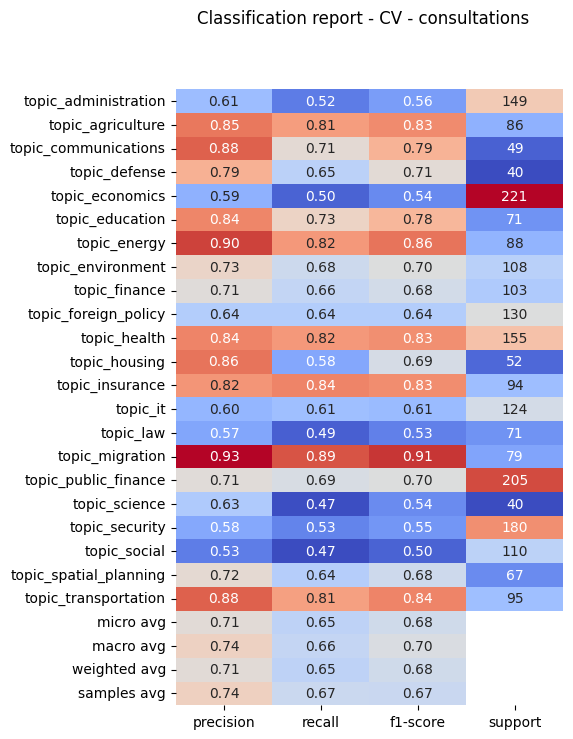

<Figure size 640x480 with 0 Axes>

In [96]:
fig = plotting.plot_classification_report_heatmap(
    y_cv_true_consultations.values,
    y_cv_predicted_consultations.values,
    target_names=topic_columns,
)
fig.suptitle("Classification report - CV - consultations")
plt.tight_layout()
mlflow.log_figure(fig, "cv_classification_report_consultations.png")
fig

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


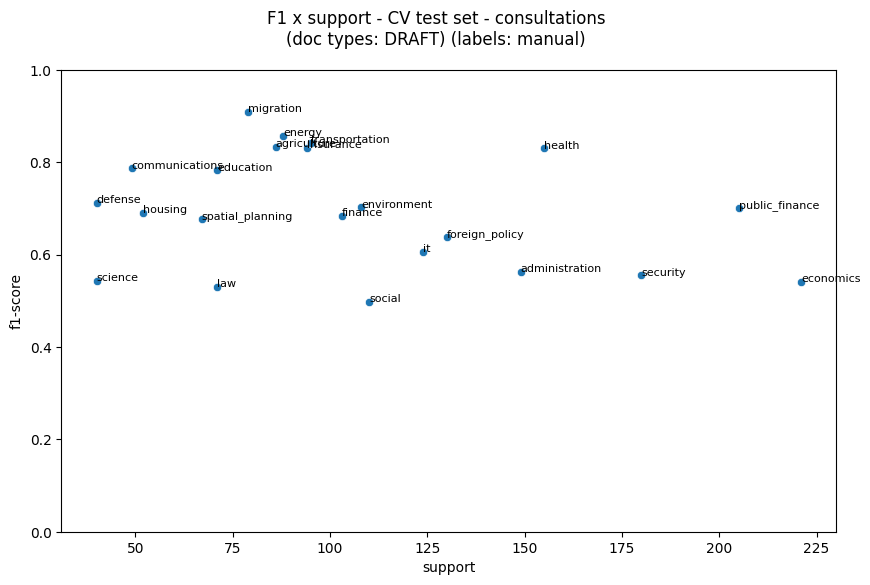

<Figure size 640x480 with 0 Axes>

In [97]:
fig = plotting.plot_score_against_support(
    y_cv_true_consultations.values,
    y_cv_predicted_consultations.values,
    target_names=topic_columns,
)
# document_sources = "+".join(sorted(DOCUMENT_SOURCES))
document_types = "+".join(sorted(t if t else "unknown" for t in DOC_TYPES))
label_sources = "+".join(sorted(df_input["consultation_topics_label_source"].unique()))
fig.suptitle(
    "\n".join(
        [
            # f"F1 x support - CV test set - consultations (data: {document_sources})",
            "F1 x support - CV test set - consultations",
            f"(doc types: {document_types}) (labels: {label_sources})",
        ]
    )
)
plt.tight_layout()
mlflow.log_figure(fig, "cv_score_against_support_consultations.png")
fig

## Training

2025/07/15 10:04:31 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2025/07/15 10:04:44 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: Found array with dim 3, while dim <= 2 is required.
2025/07/15 10:04:44 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: Found array with dim 3, while dim <= 2 is required.
2025/07/15 10:04:45 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: multilabel-indicator is not supported
2025/07/15 10:04:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


''

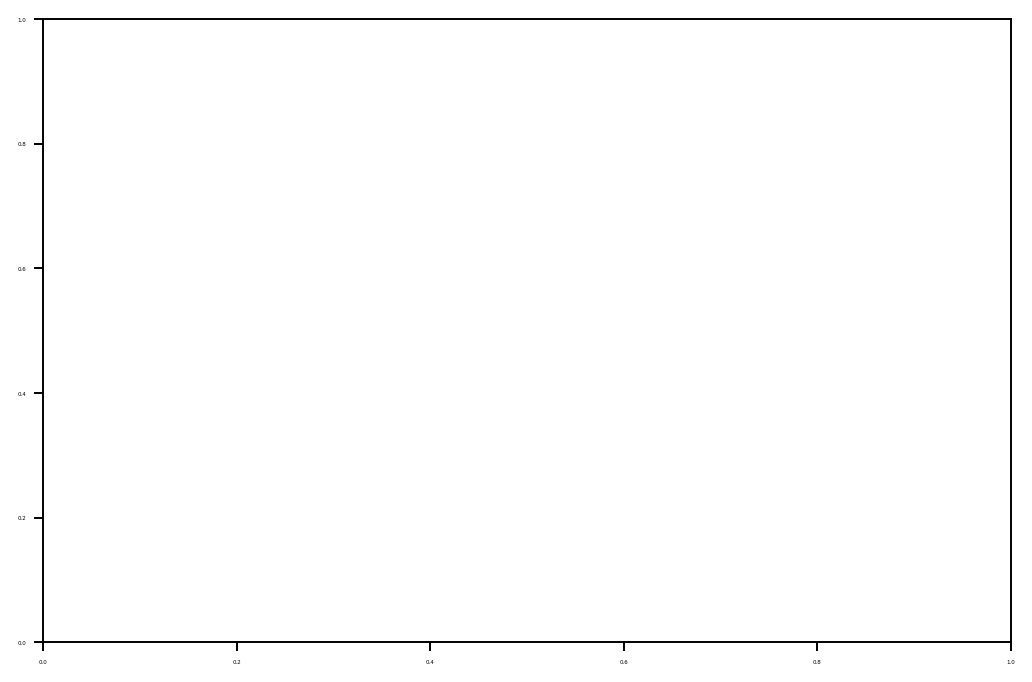

In [98]:
classifier_test = create_classifier(RANDOM_STATE)
classifier_test.fit(X_train, y_train)
;

## Evaluation on the test set

In [99]:
y_test_predicted_docs = classifier_test.predict(X_test)

y_test_true_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_identifiers=df_input_test["consultation_identifier"],
    label_names=topic_columns,
    doc_labels=y_test.values,
)
y_test_predicted_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_identifiers=df_input_test["consultation_identifier"],
    label_names=topic_columns,
    doc_labels=y_test_predicted_docs,
)

In [100]:
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    y_test_true_consultations,
    y_test_predicted_consultations,
    average="samples",
    zero_division=np.nan,
)
scores_consultations = {"test_precision": precision, "test_recall": recall, "test_f1": f1}
print("Per-consultation scores:")
utils.log_metrics(**scores_consultations)

Per-consultation scores:
{'test_f1': 0.7044, 'test_precision': 0.7798, 'test_recall': 0.6963}


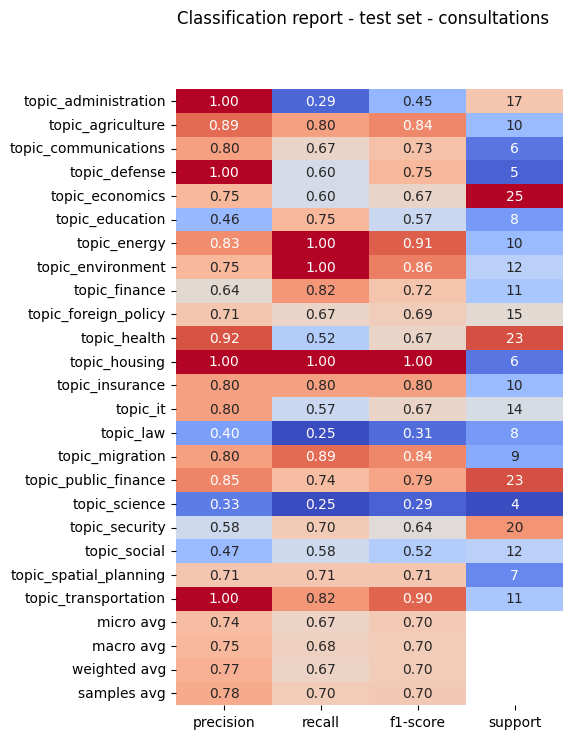

<Figure size 640x480 with 0 Axes>

In [101]:
fig = plotting.plot_classification_report_heatmap(
    y_test_true_consultations,
    y_test_predicted_consultations,
    target_names=topic_columns,
)
fig.suptitle("Classification report - test set - consultations")
mlflow.log_figure(fig, "test_classification_report_consultations.png")
plt.tight_layout()
display(fig)

***

# End MLflow run

In [102]:
mlflow.end_run()

🏃 View run flawless-cod-402 at: https://mlflow.ml1.demokratis.ch/#/experiments/5/runs/b0da5ebc10a548adb19d0296fd272cd2
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/5
